# Problem definition

In addition to providing abstractions for solving optimisation problems, Stride introduces a series of utilities for users to specify the characteristics of the problem being solved, such as the physical properties of the medium or the sequence in which transducers are used.

## Spatiotemporal grid

In Stride, the problem is first defined over a spatiotemporal grid, which determines the spatial and temporal bounds of the problem and their discretisation. 

In [1]:
from stride import Space, Time, Grid

space = Space(shape=(100, 100), spacing=0.5e-3)
time = Time(start=0.0e-6, step=0.1e-6, num=1000)

grid = Grid(space, time)

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


It is important to note that Stride considers all variables to be written in SI units. Currently, we support discretisations over rectangular grids, but other types of meshes could be introduced in the future.

## Medium

On this spatiotemporal mesh, we define a series of grid-aware data containers, which include scalar and vector fields, and time traces. These data containers are subclasses of ``stride.Variable``.

Based on this, we can define a medium, a ``stride.Medium`` object, a collection of fields that determine the physical properties in the region of interest. For instance, the medium could be defined by two ``stride.ScalarField`` objects containing the spatial distribution of longitudinal speed of sound and density.

In [2]:
from stride import Medium, ScalarField

medium = Medium(grid=grid)

medium.add(ScalarField(name="vp", grid=grid))
medium.add(ScalarField(name="rho", grid=grid))

medium.vp.fill(1500.)
medium.rho.fill(1000.)

## Transducers and geometry

Next, we can define the transducers, the computational representation of the physical devices that are used to emit and receive sound, characterised by aspects such as their geometry and impulse response. 

These transducers are then located within the spatial grid by defining a series of locations in a ``stride.Geometry``. In the next cell we instantiate some ``stride.Transducer`` objects and then add them to a corresponding ``stride.Geometry``.

<Axes: title={'center': 'geometry'}>

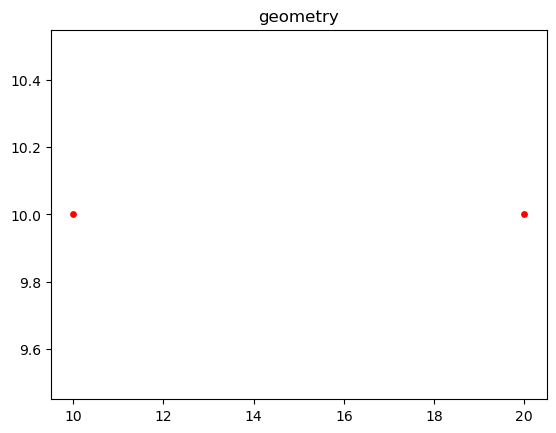

In [5]:
from stride import PointTransducer, Transducers, Geometry

# Create some transducers
transducer_0 = PointTransducer(id=0, grid=grid)
transducer_1 = PointTransducer(id=1, grid=grid)
print(grid)

# and add them to a container
transducers = Transducers(grid=grid)
transducers.add(transducer_0)
transducers.add(transducer_1)

# Create a geometry
geometry = Geometry(transducers=transducers, grid=grid)

# and add the locations of the transducers within the geometry
geometry.add(id=0, transducer=transducer_0, coordinates=[10.0e-3, 10.0e-3])
geometry.add(id=1, transducer=transducer_1, coordinates=[20.0e-3, 10.0e-3])

geometry.plot()

## Acquisition sequence

Finally, we can specify an acquisition sequence within a ``stride.Acquisitions`` object. 

The acquisition sequence is composed of shots (``stride.Shot`` objects), where each shot determines which transducers at which locations act as sources and/or receivers at any given time during the acquisition process. The shots also contain information about the wavelets used to excite the sources and the data observed by the corresponding receivers if this information is available.

In [4]:
from stride import Shot, Acquisitions
from stride.utils import wavelets

loc_0 = geometry.get(0)
loc_1 = geometry.get(1)

# Create a shot
shot = Shot(id=0, 
            sources=[loc_0], 
            receivers=[loc_0, loc_1],
            geometry=geometry,
            grid=grid)

# add a wavelet to it
f_centre = 0.5e6
n_cycles = 3
shot.wavelets.data[0] = wavelets.tone_burst(f_centre, n_cycles, time.num, time.step)

# and add it to the acquisition
acquisitions = Acquisitions(geometry=geometry, grid=grid)
acquisitions.add(shot)

## Problem

All components of the problem definition can be stored in a `stride.Problem` object, which structures them in a single, common entity.

In [5]:
from stride import Problem

problem = Problem(name="example", grid=grid)
problem.geometry.plot()

By default, the `problem` object contains a medium under `problem.medium`, transducers and geoemtry under `problem.transducers` and `problem.geometry`, and an acquisition sequence under `problem.acquisitions`.